The work presented in this notebook is based on this discussion: https://quantumcomputing.stackexchange.com/questions/13051/how-is-it-possible-to-guess-what-state-the-qubit-was-in-by-measuring-it/13055#13055 .

# Imports

In [1]:
# To install Qiskit, uncomment and run the line below
# !pip install -r requirements.txt --quiet

# If you haven't used your IBMQ account yet, load it using your TOKEN:
# IBMQ.save_account(TOKEN)

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute
from qiskit.quantum_info.operators import Operator
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Provider and backends

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')
backend_qc = provider.get_backend('ibmq_manila')
backend_qc_sim = QasmSimulator.from_backend(backend_qc)

# Quantum Tomography of 1 qubit

Any 1 qubit state can be written in the form
$$
\left\vert \psi\right\rangle =e^{i\gamma}\left(\cos\left(\frac{\theta}{2}\right)\left\vert 0\right\rangle +\sin\left(\frac{\theta}{2}\right)e^{i\phi}\left\vert 1\right\rangle \right)
$$

It is intuitive to see that having 3 free parameters makes sense,
since we have 4 parameters (real and complex parts of each of the
2 coefficients) but we also have the constraint of the state being
normalized, which $\left|\alpha\right|^{2}+\left|\beta\right|^{2}=1$
for a general case $\left\vert \psi\right\rangle =\alpha\left\vert 0\right\rangle +\beta\left\vert 1\right\rangle $.
However, the global phase should be completely irrelevant for any
procedure, so now we'll show 3 tests that can be applied to a quantum
state, provided that we can prepare a system in that state as many
times as we want, and that enable us to determine $\theta$ and $\phi$
to obtain:
$$
\left\vert \psi\right\rangle =\cos\left(\frac{\theta}{2}\right)\left\vert 0\right\rangle +\sin\left(\frac{\theta}{2}\right)e^{i\phi}\left\vert 1\right\rangle 
$$

The intervals for each angle are $\theta\in\left[0,\pi\right]$ and
$\phi\in[-\pi,\pi)$.

In this notebook we implement 3 test that can determine any 1 qubit state in this specific form.

Let's generate a random 1 qubit state:

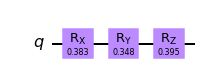

In [4]:
psi_circ = QuantumCircuit(1)
tx, ty, tz = np.random.random(3)
psi_circ.rx(tx, 0)
psi_circ.ry(ty, 0)
psi_circ.rz(tz, 0)
psi_circ.draw()

In [5]:
psi = psi_circ.to_gate(label=r'$\left\vert \psi\right\rangle$')

In [14]:
def state(tx, ty, tz):
    c, s = np.cos(tx/2), np.sin(tx/2)
    
    rx = np.array([[    c, -1j*s],
                   [-1j*s,     c]])
    
    c, s = np.cos(ty/2), np.sin(ty/2)
    
    ry = np.array([[    c,    -s],
                   [    s,     c]])
    
    rz = np.array([[np.exp(-1j*tz/2),               0],
                   [               0, np.exp(1j*tz/2)]])
    return np.dot(rz @ ry @ rx, np.array([1, 0]))

def canonical(s):
    norm_a, norm_b = np.absolute(s)
    theta_a, theta_b = np.angle(s)
    phi = theta_b - theta_a
    return np.array([norm_a, norm_b*np.exp(1j*phi)])

state = canonical(state(tx, ty, tz))
print(f'the canonical form of the state is {state}')

the canonical form of the state is [0.96741327+0.j         0.22537093-0.11541021j]


## Test 1 - determine $\theta$

The circuit for this test is:

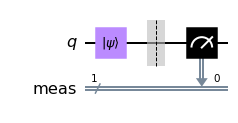

In [7]:
test1 = QuantumCircuit(1)
test1.compose(psi, inplace=True)
test1.measure_all()
test1.draw()

We know that the probabilities of measuring 0 and 1 ($P_{0}$ and
$P_{1}$) are:
$$
\begin{align*}
P_{0} & =\cos^{2}\left(\frac{\theta}{2}\right)\\
P_{1} & =\sin^{2}\left(\frac{\theta}{2}\right)
\end{align*}
$$

which gives us $\frac{\theta}{2}\in\left[0,\frac{\pi}{2}\right]$:
$$
\theta=2\arccos\left(\sqrt{P_{0}}\right)=2\arcsin\left(\sqrt{P_{1}}\right)
$$

If this experiments give $\theta=0$ or $\theta=\pi$, we'll already
know $\left\vert \psi\right\rangle =\left\vert 1\right\rangle $ or
$\left\vert \psi\right\rangle =\left\vert 0\right\rangle $ respectively,
so in that case we skip the next tests.


## Test 2 - determine $\left|\phi\right|$

The circuit for this test is:

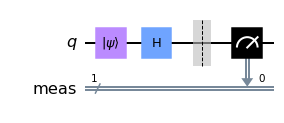

In [8]:
test2 = QuantumCircuit(1)
test2.compose(psi, inplace=True)
test2.h(0)
test2.measure_all()
test2.draw()

The final state is:
$$
\left\vert \psi_{1}\right\rangle=\frac{1}{\sqrt{2}}\left[\cos\left(\frac{\theta}{2}\right)+\sin\left(\frac{\theta}{2}\right)e^{i\phi}\right]\left\vert 0\right\rangle +\frac{1}{\sqrt{2}}\left[\cos\left(\frac{\theta}{2}\right)-\sin\left(\frac{\theta}{2}\right)e^{i\phi}\right]\left\vert 1\right\rangle 
$$

which implies:

\begin{align*}
P_{0} & =\frac{1}{2}\left[1+\sin\left(\theta\right)\cos\left(\phi\right)\right] & P_{1} & =\frac{1}{2}\left[1-\sin\left(\theta\right)\cos\left(\phi\right)\right]
\end{align*}

We can manipulate this as

$$ \left|\phi\right| =\left|\arccos\left(\frac{P_{0}-P_{1}}{\sin\left(\theta\right)}\right)\right| $$


## Test 3 - determine sign($\phi$)

The circuit for this test is:

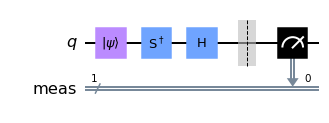

In [9]:
test3 = QuantumCircuit(1)
test3.compose(psi, inplace=True)
test3.sdg(0)
test3.h(0)
test3.measure_all()
test3.draw()

The final state is:

$$
\left\vert \psi \right\rangle =\frac{1}{\sqrt{2}}\left[\cos\left(\frac{\theta}{2}\right)-i\sin\left(\frac{\theta}{2}\right)e^{i\phi}\right]\left\vert 0\right\rangle +\frac{1}{\sqrt{2}}\left[\cos\left(\frac{\theta}{2}\right)+i\sin\left(\frac{\theta}{2}\right)e^{i\phi}\right]\left\vert 1\right\rangle 
$$

which implies:

\begin{align*}
P_{0} & =\frac{1}{2}\left[1+\sin\left(\theta\right)\sin\left(\phi\right)\right] & P_{1} & =\frac{1}{2}\left[1-\sin\left(\theta\right)\sin\left(\phi\right)\right]
\end{align*}

which can be combined to give
\begin{align*}
\sin\left(\phi\right) & =\frac{P_{0}-P_{1}}{\sin\left(\theta\right)}\\
sign\left(\phi\right) & =sign\left(\arcsin\left(\frac{P_{0}-P_{1}}{\sin\left(\theta\right)}\right)\right)\\
sign\left(\phi\right) & =sign\left(P_{0}-P_{1}\right)
\end{align*}

where we used that the range of usual principal value or arcsin is
$\left[-\frac{\pi}{2},\frac{\pi}{2}\right]$ and $\sin\left(\theta\right)>0\,\,\forall\theta\in\left(0,\pi\right)$.


## Tomography function

In [37]:
def tomography(all_counts):
    counts1 = all_counts[0]
    shots1 = sum(counts1.values())
    
    p1_0 = counts1.get('0', 0)/shots1
    p1_1 = counts1.get('1', 0)/shots1
    
    norm0 = np.sqrt(p1_0)
    norm1 = np.sqrt(p1_1)
    
    if abs(norm0) < 1e-12:
        return np.array([0.0, 1.0])
    if abs(norm1) < 1e-12:
        return np.array([1.0, 0.0])
    
    counts2 = all_counts[1]
    shots2 = sum(counts2.values())
    
    p2_0 = counts2.get('0', 0)/shots2
    p2_1 = counts2.get('1', 0)/shots2
    
    theta = 2*np.arccos(np.sqrt(p1_0))
    abs_phi = np.absolute(np.arccos((p2_0-p2_1) / np.sin(theta)))
    
    counts3 = all_counts[2]
    shots3 = sum(counts3.values())
    
    p3_0 = counts3.get('0', 0)/shots3
    p3_1 = counts3.get('1', 0)/shots3
    
    sign_phi = np.sign(p3_0 - p3_1)
    
    return np.array([norm0, norm1*np.exp(1j*sign_phi*abs_phi)])

## Running the tests

In [38]:
state

array([0.96741327+0.j        , 0.22537093-0.11541021j])

In [39]:
job = execute([test1, test2, test3], backend=backend_sim, shots=2**18)
tomography(job.result().get_counts())

array([0.96751078+0.j        , 0.22540568-0.11452144j])

We thus see that the theoretical state in canonical form and the state we determined through the 3 test are the same up to the 4th decimal place.

In [12]:
%qiskit_version_table